### Interactive CORTX Metrics Graphs Creation

In [2]:
%cd /home/johnbent/cortx/metrics
import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cortx_community
import cortx_graphing
import datetime

%matplotlib inline
ps=cortx_community.PersistentStats()

/home/johnbent/cortx/metrics


In [3]:
# we currently have a bad scrape in the pickle (i.e. '2020-12-20'); instead of removing it just hide it here
def remove_date(df,date):
    try:
        df=df.drop(date,axis=0) # this first scrape was no good, double counted issues and pulls
    except KeyError:
        pass # was already dropped
    return df

In [4]:
# turn a repo (e.g. 'cortx-s3server') into a dataframe suitable for plotting
def get_dataframe(repo,ps):
    return cortx_graphing.get_dataframe(repo,ps)

In [5]:
# using a dataframe, create a plot of just a subset of its columns
def compare_values(repo,ps,targets):
    df=get_dataframe(repo,ps)
    df[targets].plot(title="Repo %s" % repo)

In [6]:
# a function that makes a graph showing the count for all repos for a particular field
# note that it explicitly filters 'GlOBAL' out
def compare_repos(target,ps):
    repos=ps.get_repos()
    dates=ps.get_dates('cortx')
    data={}
    for repo in repos:
        if repo != 'GLOBAL':
            data[repo]=ps.get_values_as_numbers(repo,target,dates)
    df=pd.DataFrame(data=data, index=dates)
    df=remove_date(df,'2020-12-20')
    #print(df)
    df.plot(title=target)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
# adds some new columns to the dataframe doing math on the other and then plots them
def compare_merge_rates(repo,ps):
    df = get_dataframe(repo,ps)
    # make some new columns on the basis of the existing columns
    for k in ['external','internal']:
        df['%s_merge_rate' % k] = df['pull_requests_%s_merged' % k] / df['pull_requests_%s' % k]
    # plot just a few of the columns (the newly created ones)
    df[['external_merge_rate','internal_merge_rate']].plot(ylim=(0,1),title="Merge Rates for %s" % repo)

In [8]:
# for every field in the metrics, make a graph comparing the repos
def make_all_graphs_comparing_repos(ps):
    (latest,date)=ps.get_latest('cortx')
    for k in sorted(latest.keys()):
        compare_repos(k,ps)

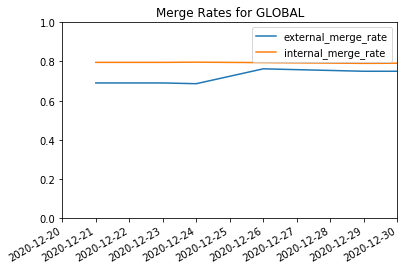

In [9]:
compare_merge_rates('GLOBAL',ps)

In [ ]:
compare_values('GLOBAL',ps,['pull_requests','pull_requests_external','pull_requests_internal'])

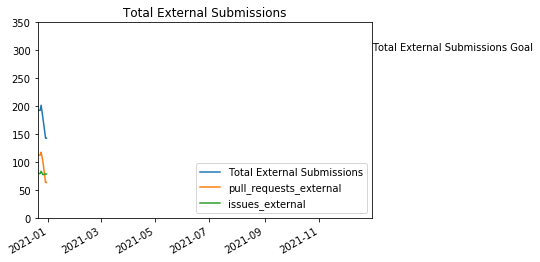

In [26]:
df=get_dataframe('GLOBAL',ps)
title='Total External Submissions'
df[title] = df['pull_requests_external'] + df['issues_external']
df=remove_date(df,'2020-12-20')
ylim=(0,350)
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(None,goal_date)
df[[title,'pull_requests_external','issues_external']].plot(ylim=ylim,xlim=xlim,title=title)
plt.annotate("%s Goal" % title, (goal_date, 300))
plt.legend(loc='lower right')
plt.show()

In [ ]:
df=get_dataframe('cortx',ps)
columns=[]
for label, content in df.items():
    if 'ave_age_in_s' in label and 'pull' in label and ('external' in label or 'internal' in label) and 'closed' in label:
        new_label = label.replace('_in_s','_in_days')
        df[new_label] = df[label]/86400
        columns.append(new_label)
df[columns].plot(ylim=(0,None))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
make_all_graphs_comparing_repos(ps)